In [1]:
#
# phase2 :
#   Banana model inference
#
%matplotlib inline
import os
os.environ['THEANO_FLAGS'] = "mode=FAST_RUN,device=cpu,floatX=float32"
import theano
import theano.tensor as T
import config
import numpy as np
import matplotlib.pyplot as plt

/Library/Python/2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
import network
import network.normFlow as nf
import utils
import utils.mathT as mathT
import utils.mathZ as mathZ
import utils.theanoGeneral as utilsT
import utils.optimizers as optimizers
import utils.plotZ as plotZ
import models
import models.mars as mars
import seaborn as sns
DIM = 2
SAMPLINGNUM = 20
floatX = utils.floatX

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [491]:
LOW,HIGH = -5,+5

In [492]:
# constructing graphical model
reload(models.mars)
ROOT = '../report/figs/inference/'

# MODEL_NAME = 'orange'

# energy based model
# model = mars.Loquat();  MODEL_NAME = 'loquat'
model = mars.Apple();   MODEL_NAME = 'apple'
# model = mars.Lemon();   MODEL_NAME = 'lemon'
# model = mars.Orange();  MODEL_NAME = 'orange'


OUTPATH = ROOT + '/'+MODEL_NAME

(10000,)
-3.21271981929e-28 -112.5
saving to ../report/figs/inference//apple/apple.png


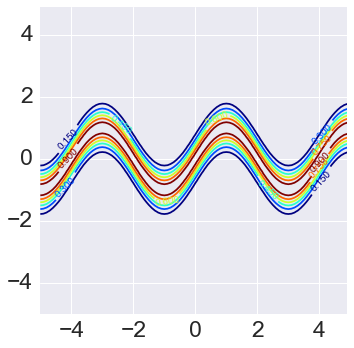

In [493]:
# plot true posterior
GAP = ( HIGH - LOW )/100.
gz, g1, g2 = mathZ.gridPoints( (LOW,HIGH,GAP), (LOW,HIGH,GAP) )

# bnn
logs = model.nlogPz(gz)
print logs.shape
print np.max(logs,axis=0), np.min(logs,axis=0)
gpz = np.exp( logs.reshape(g1.shape[1],g2.shape[0]) )
# gpz = logs.reshape(g1.shape[1],g2.shape[0])

fig = plt.figure()
CS = plt.contour(g1,g2,gpz,cmap='jet')  # 'YlOrRd'
plt.clabel(CS, inline=1, fontsize=10)
plt.axes().set_aspect('equal')
plt.tick_params(axis='both', which='major', labelsize=23)
plt.savefig(OUTPATH+'/%s.png'%(MODEL_NAME))
print 'saving to %s' % OUTPATH+'/%s.png'%(MODEL_NAME)
plt.show()

In [494]:
###
### SETUP
###
SAVE_FLAG = True

NUM_LAYERS = 32
NF_TYPE, STD = 'normal', 1.0
# NF_TYPE, STD = 'uniform', 3
NUMITER = 20000
ziters = [9999,NUMITER-1]
print '\nSaving flag : %s\n\nnf type : %s, %dlayers\nstd : %0.2f\nnum iter : %d\niters recording : %s' % \
    ( SAVE_FLAG, NF_TYPE, NUM_LAYERS, STD, NUMITER, ziters )


Saving flag : True

nf type : normal, 32layers
std : 1.00
num iter : 20000
iters recording : [9999, 19999]


In [495]:
# construction variational model
iaf = nf.NormFlowModel( dim=DIM, numlayers=NUM_LAYERS,noisestd=STD,z0type=NF_TYPE )  #(4./DIM)**.5
e = iaf.getNoiseVar(SAMPLINGNUM)
z, logqz = iaf.reparam(e)

# setting cost variable
logpxz,_,_ = model.logPxz(z)
cost = T.mean( logqz - logpxz )  # negative-ELBO

params = iaf.getParams()
grads = [ T.grad(cost,p,consider_constant=[e]) for p in params ]

In [496]:
# optimisation setup
iaf.reInit()
opt = optimizers.SGD(params,lr=0.05,momentum=0.5,decay=0.001)
updates = opt.getUpdates(params,grads)

outputs = [ cost, T.mean(logpxz), T.mean(logqz) ]
estep = theano.function(inputs=[],outputs=outputs,updates=updates)

In [497]:
# for presentation
e2 = iaf.getNoiseVar(50000)
z2, logqz2 = iaf.reparam(e2)
fez2 = theano.function(inputs=[],outputs=[e2,z2])

In [498]:
# training
keys = ['cost','pxz','qz']
record = {'iters':ziters, 'zs':[]}
for k in keys:
    record[k] = []

iterset = set( ziters )    
for i in range(NUMITER):
    # apple
    out = estep()
    for k,q in enumerate(out):
        record[keys[k]].append( q )        
    if i in iterset:
        record['zs'].append(fez2()[1])
        print 'samples recorded: iter %d'% i
        
for k in keys:
    record[k] = np.asarray( record[k] )

samples recorded: iter 9999
samples recorded: iter 19999


saving to ../report/figs/inference//apple/elbo_L32.png


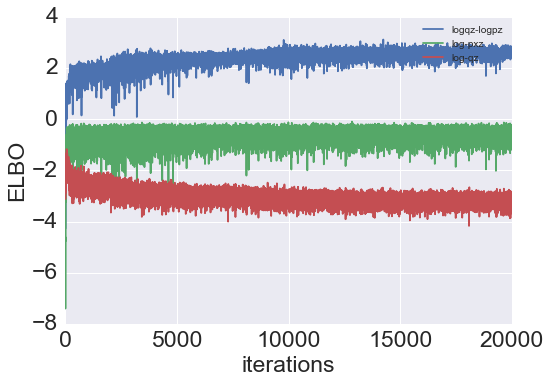

In [499]:
# plot variational bound
xs = range(NUMITER)
# xs = range(500)
plt.plot( xs, -record['cost'][xs], '-', label='logqz-logpz')
plt.xlabel('iterations',fontsize=23)
plt.ylabel('ELBO',fontsize=23)
plt.tick_params(axis='both', which='major', labelsize=23)
if SAVE_FLAG:
    plt.savefig(OUTPATH+'/elbo_L%d.png'%(NUM_LAYERS))
    print 'saving to %s' % OUTPATH+'/elbo_L%d.png'%(NUM_LAYERS)
plt.plot( xs, record['pxz'][xs], '-', label='log-pxz')
plt.plot( xs, record['qz'][xs], '-', label='log-qz')
plt.legend()
plt.show()

saving to ../report/figs/inference//apple/qz_L32_normal.png


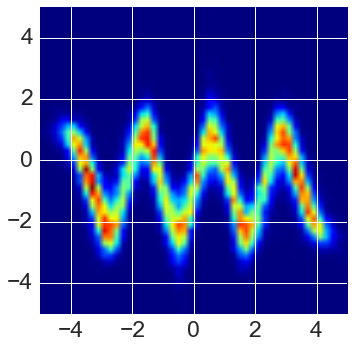

In [500]:
# estimated posterior
es, zs = fez2()
# zs = record['zs'][1]
heatmap, xedges, yedges = np.histogram2d( zs[:,0], zs[:,1], bins=50)
extent = [LOW, HIGH, LOW,HIGH]
# extent = [xedges[0],xedges[-1],yedges[0],yedges[-1]]

plt.imshow(heatmap.T, extent=extent, origin='lower',cmap='jet')
plt.tick_params(axis='both', which='major', labelsize=23)
if SAVE_FLAG:
    plt.savefig( OUTPATH+'/qz_L%d_%s.png'%(NUM_LAYERS,NF_TYPE))
    print 'saving to %s' % OUTPATH+'/qz_L%d_%s.png'%(NUM_LAYERS,NF_TYPE)

In [501]:
###
### SAVE
###
SAVEPATH = (OUTPATH +'/record_L%d_%s.npz')%(NUM_LAYERS,NF_TYPE)
if SAVE_FLAG:
    np.savez(SAVEPATH, cost=record['cost'], zs=record['zs'],iters=record['iters'], numiters=NUMITER, numlayers=NUM_LAYERS, std=STD )
    print 'record saved to %s' % SAVEPATH
else:
    print 'UNSAVED'

record saved to ../report/figs/inference//apple/record_L32_normal.npz


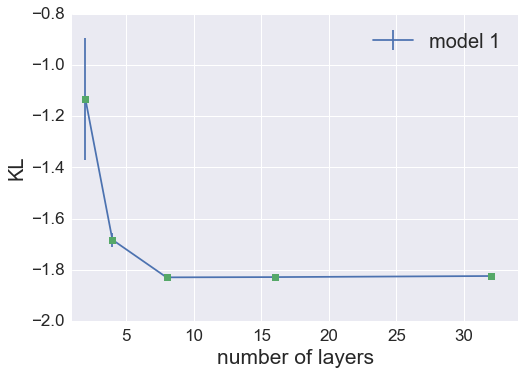

In [526]:
## INDEPENDENT
##     Statistica of the variational bound
##

NAMES = ['loquat','apple','lemon','orange']
NUM_LS = [2,4,8,16,32]

MID = 0
NAME = NAMES[MID]


RPATH = '../report/figs/inference/%s' % NAME
rs = list()
costs = list()
for i, L in enumerate(NUM_LS):
    rs.append(  np.load(RPATH+'/record_L%d_normal.npz'%L) )
    costs.append( rs[-1]['cost'][-500:] )
costs = np.asarray( costs )
bars = [ np.var(costs[i]) for i in range(len(NUM_LS)) ]
costs = np.mean(costs,axis=1)


plt.errorbar(NUM_LS,costs,yerr=bars, label='model '+str(MID+1))
plt.plot( NUM_LS, costs, 's')
    
plt.xlabel('number of layers',fontsize=21)
plt.ylabel('KL',fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=17)
plt.xlim([1,NUM_LS[-1]+2])
plt.legend(fontsize=20)

plt.savefig(RPATH+'/KLvsL.png')
